# Capstone project for Applied Data Science Coursera course

## Preliminaries:

Import packages:

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from datetime import date #get system date

#!pip install wget
import wget

import urllib.request, json 

import pickle

!pip install seaborn --upgrade
import seaborn as sns

Requirement already up-to-date: seaborn in /opt/anaconda3/lib/python3.7/site-packages (0.11.1)


Download and open New York City data:

In [3]:
with urllib.request.urlopen("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json") as url:
    newyork_data = json.loads(url.read().decode())
    #print(data)

In [4]:
neighborhoods_data = newyork_data['features']

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Loop through data and add it to data frame:

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Examine the data frame:

In [7]:
print(neighborhoods.shape)
neighborhoods.head()

(306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Use Geopy to get geocode values:

In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Create a map with neighborhoods superimposed:

In [9]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Now use Foursquare API to get venue data for all the neighborhoods:

Input foursquare user credentials:

In [10]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


Define function to get foursquare categories (Below is a modified version of the function that includes venue ID as well (needed below for getting ratings):

In [11]:
def getNearbyVenues_v2(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results]) #this line added in v2 of function, to pull the id
        #this loops through the items of the results list
        #note, if you check these code lines for the whole results list, you need to include an index:
        #eg: v[0]['venue']['categories'][0]['name']

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID'] #this added in v2 of function to give name to column ID
    
    return(nearby_venues)

Download json file for venues in all NYC neighborhoods. This is commented, because you can simply open the pickle I've saved from running this code earlier.

In [12]:
#ny_venues = getNearbyVenues_v2(names=neighborhoods['Neighborhood'],
#                                  latitudes = neighborhoods['Latitude'],
#                                  longitudes = neighborhoods['Longitude'])

Save output file as a pickle in case we want to pull it up later. This is commented, because I ran it earlier to save the pickle.

In [13]:
#filename = 'ny_venues_v2_' + date.today().strftime("%m-%d-%Y") + '.pkl'
#ny_venues.to_pickle(filename)

Load saved pickle with ny venues data:

In [14]:
pickle_in = open("ny_venues_v2_12-30-2020.pkl","rb")
ny_venues = pickle.load(pickle_in)

Check size and format of data frame:

In [15]:
print(ny_venues.shape)
ny_venues.head()

(10159, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,4c537892fd2ea593cb077a28
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,4d6af9426107f04dedeb297a
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,4c783cef3badb1f7e4244b54
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy,5d5f5044d0ae1c0008f043c3
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,4c25c212f1272d7f836385c5


Let's see how many neighborhoods there are, and how many venues in each:

In [16]:
print(ny_venues.groupby('Neighborhood').count().shape)
ny_venues.groupby('Neighborhood').count()

(301, 7)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
Neighborhood,,,,,,,
Allerton,31,31,31,31,31,31,31
Annadale,11,11,11,11,11,11,11
Arden Heights,6,6,6,6,6,6,6
Arlington,4,4,4,4,4,4,4
Arrochar,23,23,23,23,23,23,23
Arverne,20,20,20,20,20,20,20
Astoria,100,100,100,100,100,100,100
Astoria Heights,10,10,10,10,10,10,10
Auburndale,18,18,18,18,18,18,18


### Calculate proportions of each venue type for each neighborhood:

Start by creating data frame with dummy variables for category for each venue:

In [17]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
#fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
index = ny_onehot.columns.get_loc("Neighborhood")
fixed_columns = [ny_onehot.columns[index]] + list(ny_onehot.columns[:index-1]) + list(ny_onehot.columns[index+1:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,O

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [18]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,O

Now to create a data frame containing the most common venues for each neighborhood. First define a function:

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[indf]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Chinese Restaurant,Supermarket,Grocery Store,Martial Arts School,Electronics Store,Fast Food Restaurant,Pharmacy,Gas Station
1,Annadale,Bakery,Park,Pizza Place,Train Station,Liquor Store,Food,Pharmacy,Diner,Restaurant,Deli / Bodega
2,Arden Heights,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Business Service,Pizza Place,Women's Store,Film Studio,Exhibit,Factory
3,Arlington,ATM,Deli / Bodega,American Restaurant,Bus Stop,Fish Market,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
4,Arrochar,Bus Stop,Deli / Bodega,Italian Restaurant,Bagel Shop,Pizza Place,Supermarket,Middle Eastern Restaurant,Pharmacy,Liquor Store,Outdoors & Recreation


# Types of venues

Get the counts for all venue types in the city:

In [21]:
ny_venues.groupby('Venue Category').count().sort_values(by = 'Neighborhood', ascending = False)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID
Venue Category,,,,,,,
Pizza Place,440,440,440,440,440,440,440
Coffee Shop,320,320,320,320,320,320,320
Italian Restaurant,310,310,310,310,310,310,310
Deli / Bodega,296,296,296,296,296,296,296
Bakery,233,233,233,233,233,233,233
Bar,223,223,223,223,223,223,223
Chinese Restaurant,220,220,220,220,220,220,220
Grocery Store,195,195,195,195,195,195,195
Sandwich Place,181,181,181,181,181,181,181


## Now we want to download ratings for all the pizza places. There are fewer than 500, so we can do it on a free Personal account.

Start by creating a data frame with only pizza places, and looking at its size, and head:

In [22]:
pz = ny_venues.loc[ny_venues['Venue Category'] == 'Pizza Place'] 
print(pz.shape)
pz.head()

(440, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
10,Co-op City,40.874294,-73.829939,Capri II Pizza,40.876374,-73.829940,Pizza Place,4d2cfa5cad25224bbbc5fb8f
23,Eastchester,40.887556,-73.827806,Mario's Pizza,40.888628,-73.831260,Pizza Place,4c632f1cde1b2d7fed31e470
64,Kingsbridge,40.881687,-73.902818,Kingsbridge Social Club,40.884581,-73.901999,Pizza Place,58935fd798f8aa7c14662653
66,Kingsbridge,40.881687,-73.902818,Sam's Pizza,40.879435,-73.905859,Pizza Place,4bb114c4f964a520b9783ce3
84,Kingsbridge,40.881687,-73.902818,Broadway Pizza & Pasta,40.878822,-73.904494,Pizza Place,4be72770910020a16f1ad514


### Create a function to pull the ratings for ALL the pizza places in New York.

In [23]:
def getVenueRatings(names, refIDs):
    
    ratings_list=[]
    for name, refID in zip(names, refIDs):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            refID,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION
            )
            
        # make the GET request
        results = requests.get(url).json()
        
        #get rating. Return NaN if there are no ratings.
        try:
            rating = results['response']['venue']['rating']
        except KeyError:
            print('No ratings for this venue')
            rating = float('NaN')
        
        # return only relevant information for each nearby venue
        ratings_list.append([(
            name, 
            refID,
            rating)])
            #results['response']['venue']['rating'])])

    pz_ratings = pd.DataFrame([item for rating_list in ratings_list for item in rating_list])
    pz_ratings.columns = ['Name', 
                  'Venue ID', 
                  'Venue Rating']
    
    return(pz_ratings)

#### Run function to pull ratings for all pizza places:

Some of the venues will not have any ratings. For these, the code will print "No ratings for this venue", and the value of the ratings will be NaN.

This is commented because I've run it already; we can load the pickle below.

In [24]:
#pz_ratings = getVenueRatings(names=pz['Venue'],
#                                  refIDs = pz['Venue ID'])

Save these results to a pickle, to avoid having to run it again (it's time-consuming, and it uses up api calls):
This is commented because I've already run it and saved the pickle.

In [25]:
#filename = 'ny_ratings_' + date.today().strftime("%m-%d-%Y") + '.pkl'
#pz_ratings.to_pickle(filename)

Load pickle with previously downloaded results:

In [26]:
pickle_in = open("ny_ratings_12-31-2020.pkl","rb")
pz_ratings = pickle.load(pickle_in)

Check results:

In [27]:
pz_ratings.head(10)

,Name,Venue ID,Venue Rating
0,Capri II Pizza,4d2cfa5cad25224bbbc5fb8f,6.8
1,Mario's Pizza,4c632f1cde1b2d7fed31e470,8.1
2,Kingsbridge Social Club,58935fd798f8aa7c14662653,9.5
3,Sam's Pizza,4bb114c4f964a520b9783ce3,8.8
4,Broadway Pizza & Pasta,4be72770910020a16f1ad514,7.4
5,Little Caesars Pizza,502bd9a6e4b0bea49203e0aa,6.6
6,Papa John's Pizza,5aa003f5b6eedb52c65bddb8,6.3
7,Domino's Pizza,4b4fbdb5f964a520811327e3,5.9
8,Acapella Gourmet Pizza & Restaurant,55906dbb498e4edbe4888785,NaN
9,Mama Maria's Pizza,4bc4f4bce58e9521483cc9e1,NaN


Count pizza venues and number of non-NaN ratings.  
As of 12/20/20, there were 440 pizza places, with 356 non-NaN ratings (84 NaN's).  
These numbers may change as pizza places open/close, or as more reviews come in.  

In [28]:
print(pz_ratings.shape)
print(pz_ratings['Venue Rating'].describe())
print('Number of NA\'s:', pz_ratings['Venue Rating'].isna().sum())

(440, 3)
count    356.000000
mean       7.607865
std        0.933987
min        5.600000
25%        6.800000
50%        7.700000
75%        8.400000
max        9.500000
Name: Venue Rating, dtype: float64
Number of NA's: 84


### Merge ratings dataframe with original pizza dataframe:

In [29]:
pz2 = pz.merge(pz_ratings.drop('Name', axis = 1), on = 'Venue ID')
pz2.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Venue Rating
0,Co-op City,40.874294,-73.829939,Capri II Pizza,40.876374,-73.829940,Pizza Place,4d2cfa5cad25224bbbc5fb8f,6.8
1,Eastchester,40.887556,-73.827806,Mario's Pizza,40.888628,-73.831260,Pizza Place,4c632f1cde1b2d7fed31e470,8.1
2,Kingsbridge,40.881687,-73.902818,Kingsbridge Social Club,40.884581,-73.901999,Pizza Place,58935fd798f8aa7c14662653,9.5
3,Kingsbridge,40.881687,-73.902818,Sam's Pizza,40.879435,-73.905859,Pizza Place,4bb114c4f964a520b9783ce3,8.8
4,Kingsbridge,40.881687,-73.902818,Broadway Pizza & Pasta,40.878822,-73.904494,Pizza Place,4be72770910020a16f1ad514,7.4


#### Group by neighborhood and count pizza venues per neighborhood:

In [30]:
NeighPz = pd.DataFrame(pz2.groupby('Neighborhood').count()['Venue'])

#### Calculate average rating for each neighborhood:

In [31]:
#NeighPz['Avg Rating'] = pz2.groupby('Neighborhood').average()['Venue Rating']
RatDF = pz2.groupby('Neighborhood').mean()['Venue Rating']
RatDF.head()

Neighborhood
Allerton         6.2
Annadale         NaN
Arden Heights    7.6
Arrochar         8.4
Arverne          7.3
Name: Venue Rating, dtype: float64

In [32]:
NeighPz = ( NeighPz.merge(RatDF, on = 'Neighborhood').rename(columns={"Venue": "Count", "Venue Rating": "Avg. Rating"}).
sort_values(by = 'Count', ascending = False) )
NeighPz.head()

,Count,Avg. Rating
Neighborhood,,
South Side,12,8.683333
Belmont,10,7.925000
North Side,9,9.044444
Kingsbridge,8,7.416667
Greenpoint,7,8.100000


## Now let's visualize the distributions of pizza venue ratings, and of neighborhood averages.

In [33]:
sns.set_context("notebook", font_scale=1.4) #make font size bigger for plots, for legibility

#### Create histogram of neighborhood average rating:

Text(0.5, 1.0, 'Neighborhood Avg. Ratings')

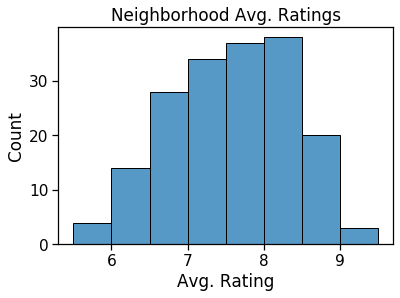

In [34]:
(sns.histplot(data = NeighPz, x = 'Avg. Rating', binwidth = 0.5, binrange = [5.5,9.5]).
set_title('Neighborhood Avg. Ratings'))

#### Create histogram of individual pizza venue ratings:

Text(0.5, 1.0, 'Pizza Venue Ratings')

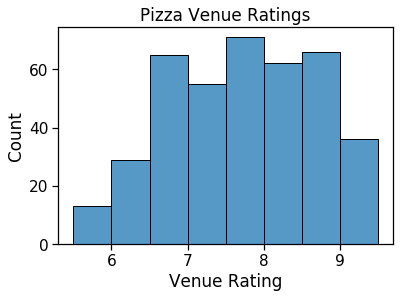

In [35]:
(sns.histplot(data = pz2, x = 'Venue Rating', binwidth = 0.5, binrange = [5.5,9.5]).
set_title('Pizza Venue Ratings'))

#### Descriptive statistics for pizza venue ratings and neighborhood-level average ratings:

In [36]:
pz2['Venue Rating'].describe() #Individual pizza venue ratings

count    397.000000
mean       7.665239
std        0.953092
min        5.600000
25%        6.900000
50%        7.800000
75%        8.500000
max        9.500000
Name: Venue Rating, dtype: float64

In [37]:
NeighPz['Avg. Rating'].describe() #Neighborhood average pizza ratings

count    178.000000
mean       7.555025
std        0.803898
min        5.800000
25%        6.937500
50%        7.600000
75%        8.200000
max        9.100000
Name: Avg. Rating, dtype: float64

## Linear regression to determine the relationship between the neighborhood count and the neighborhood average rating:

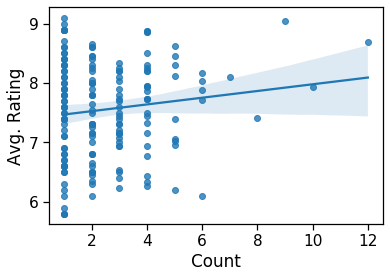

In [38]:
sns.regplot(x="Count", y="Avg. Rating", data=NeighPz);

#### Identify neighborhoods with many (>1sd above the mean) pizza places, but low (<1 sd below the mean) average ratings:

In [92]:
CT = NeighPz['Count'].mean() + NeighPz['Count'].std()
RT = NeighPz['Avg. Rating'].mean() - NeighPz['Avg. Rating'].std()
print('Count threshold: >', round(NeighPz['Count'].mean() + NeighPz['Count'].std(), 2))
print('Ratings threshold: <', round(NeighPz['Avg. Rating'].mean() - NeighPz['Avg. Rating'].std(), 2))

Count threshold: > 4.15
Ratings threshold: < 6.75


In [98]:
NeighRec = NeighPz.loc[(NeighPz['Count'] > CT) & (NeighPz['Avg. Rating'] < RT)]
NeighRec.head()

,Count,Avg. Rating
Neighborhood,,
Melrose,6,6.1
Allerton,5,6.2


### These results have identified two neighborhoods, Melrose and Allerton, as meeting our criteria for good places to open pizza venues: Melrose and Allerton.

### Make a map of neighborhoods, with colors showing average pizza ratings:

In [57]:
NeighPz2 = NeighPz.merge(neighborhoods, on = 'Neighborhood')

In [77]:
map_newyork_pz = folium.Map(location=[latitude, longitude], zoom_start=10)

#define function to return color based on rating:
def color_producer(rating):
    if rating < 6.5:
        return 'red'
    elif 6.5 <= rating < 7.5:
        return 'yellow'
    elif 7.5 <= rating < 8.5:
        return 'green'
    elif 8.5 <= rating:
        return 'blue'
    else:
        return 'white'

# add markers to map
for lat, lng, borough, neighborhood, rating, count in zip(NeighPz2['Latitude'], NeighPz2['Longitude'], NeighPz2['Borough'], NeighPz2['Neighborhood'], NeighPz2['Avg. Rating'], NeighPz2['Count']):
    label = '{}, {}, Rating = {}, Count = {}'.format(neighborhood, borough, round(rating,1), count)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        #radius=10,
        radius = count,
        popup=label,
        color='black',
        fill=True,
#        fill_color='#3186cc',
        fill_color = color_producer(rating),
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork_pz)  
    
map_newyork_pz

### Make a map of the neighborhoods we've identified as good places to open a pizzeria:

In [99]:
NeighPz3 = NeighRec.merge(neighborhoods, on = 'Neighborhood')

In [102]:
map_newyork_pz_rec = folium.Map(location=[latitude, longitude], zoom_start=10)

#define function to return color based on rating:
def color_producer(rating):
    if rating < 6.5:
        return 'red'
    elif 6.5 <= rating < 7.5:
        return 'yellow'
    elif 7.5 <= rating < 8.5:
        return 'green'
    elif 8.5 <= rating:
        return 'blue'
    else:
        return 'white'

# add markers to map
for lat, lng, borough, neighborhood, rating, count in zip(NeighPz3['Latitude'], NeighPz3['Longitude'], NeighPz3['Borough'], NeighPz3['Neighborhood'], NeighPz3['Avg. Rating'], NeighPz3['Count']):
    label = '{}, {}, Rating = {}, Count = {}'.format(neighborhood, borough, round(rating,1), count)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        #radius=10,
        radius = count,
        popup=label,
        color='black',
        fill=True,
#        fill_color='#3186cc',
        fill_color = color_producer(rating),
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork_pz_rec)  
    
map_newyork_pz_rec

## We can see that both of the neighborhoods that we recommend for starting a pizza venue are in the eastern part of the Bronx.

# This concludes the project!